<h1 style="font-size:30px;">DeepLabv3+ with ResNet50_v2 Backbone</h1>

In [1]:
#!pip install -q git+https://github.com/keras-team/keras-cv.git --upgrade

In [2]:
import glob
import os
import random
from dataclasses import dataclass, field
from datetime import datetime
from glob import glob
from pathlib import Path
from zipfile import ZipFile

import cv2
import data
import image_util as iu
import keras
import keras_cv
import matplotlib.pyplot as plt
import Models
import numpy as np
import pandas as pd
import requests
import tensorflow as tf
from dotenv import load_dotenv
from keras import layers
from keras_unet_collection import models
import metrics

ImportError: DLL load failed while importing cv2: Kan opgegeven module niet vinden.

## Set Seeds for Reproducibility

In [3]:
def system_config(SEED_VALUE):
    # Set python `random` seed.
    # Set `numpy` seed
    # Set `tensorflow` seed.
    random.seed(SEED_VALUE)
    tf.keras.utils.set_random_seed(SEED_VALUE)
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
    os.environ["TF_USE_CUDNN"] = "true"


system_config(SEED_VALUE=42)
print("TensorFlow {}; Keras {}".format(tf.__version__, keras.__version__))

TensorFlow 2.14.0; Keras 2.14.0


## Download and Extract Dataset

## Configurations

### Data Configuration

In [4]:
segments = {
    0: 'Lumen',  # Lumen
    1: 'Stenose',  # Stenose
    2: 'Multi',  # Lumen and stenose
    }

@dataclass(frozen=True)
class DatasetConfig:
    IMAGE_SIZE: tuple = (128, 128)
    BATCH_SIZE: int = 10  # 16
    NUM_CLASSES: int = 2
    BRIGHTNESS_FACTOR: float = 0.2
    CONTRAST_FACTOR: float = 0.2
    MASK: str = segments[0]

    

### Training Configuration

In [5]:
@dataclass(frozen=True)
class TrainingConfig:
    BACKBONE: str = "resnet50_v2_imagenet",
    WEIGHTS: str = 'imagenet', 
    MODEL: str = "TransUnet"
    EPOCHS: int = 200  # 100 # 35
    LEARNING_RATE: float = 1e-4
    CKPT_DIR: str = os.path.join("checkpoints_"+"_".join(MODEL.split("_")[:2]), 
                                        "deeplabv3_plus_"+"_".join(MODEL.split("_")[:2])+".h5")
    LOGS_DIR: str = os.path.join("logs_"+"_".join(MODEL.split("_")[:2]))
    HIST_DIR: str = os.path.join("history_"+"_".join(MODEL.split("_")[:2]),""+"_".join(MODEL.split("_")[:2]))


In [6]:
train_config = TrainingConfig()
data_config = DatasetConfig()

In [7]:
load_dotenv()
env_path = Path(".") / ".env"
load_dotenv(dotenv_path=env_path)
PATH = os.getenv("DATA_PATH_512")

print(PATH)

/home/bp/Development/data/DataSet/512


## Dataset Preparation

In [8]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = data.load_data_and_split(
    PATH, mask_set = data_config.MASK
)

print("Number of training samples:", len(train_x))
print("Number of validation samples:", len(valid_x))
print("Number of test samples:", len(test_x))

# print("Number of training samples:", train_y[8])
# print("Number of validation samples:", valid_x[8])
# print("Number of validation samples:", valid_y[8])
# print("Number of test samples:", test_x[8])
# print("Number of test samples:", test_y[8])

# Shuffle the data paths before data preparation.
#zipped_data = list(zip(train_x, train_y))
#random.shuffle(zipped_data)
#data_images, data_masks = zip(*zipped_data)
#data_images = list(data_images)
#data_masks = list(data_masks)

Number of training samples: 186
Number of validation samples: 23
Number of test samples: 23


In [9]:
# display(data_images)

In [10]:
# display(data_masks)

In [11]:
# display(zipped_data)

In [12]:
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y))
valid_data = tf.data.Dataset.from_tensor_slices((valid_x, valid_y))
test_data = tf.data.Dataset.from_tensor_slices((test_x, test_y))

2024-02-28 20:53:17.659634: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-28 20:53:17.662715: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-28 20:53:17.662884: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-28 20:53:17.666003: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-28 20:53:17.666034: I tensorflow/compile

### Train-Validation Split

We are maintaining a **95-5** split ratio for training and validation samples respectively.

In [13]:
#SPLIT_RATIO = 0.05
# Determine the number of validation samples
#NUM_VAL = int(len(data_images) * SPLIT_RATIO)

# Split the dataset into train and validation sets
#train_data = org_data.skip(NUM_VAL)
#valid_data = org_data.take(NUM_VAL)

In [14]:
print(f"Train samples: {train_data.cardinality().numpy()}")
print(f"Validation samples: {valid_data.cardinality().numpy()}")
print(f"Test samples: {test_data.cardinality().numpy()}")

Train samples: 177
Validation samples: 9
Test samples: 23


### Load Data and Threshold Masks

In [15]:
def read_image_mask(image_path, mask=False, size = data_config.IMAGE_SIZE):
    image = tf.io.read_file(image_path)

    if mask:
        image = tf.io.decode_image(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=size, method = "bicubic")

        image_mask = tf.zeros_like(image)
        cond = image >=200
        updates = tf.ones_like(image[cond])
        image_mask = tf.tensor_scatter_nd_update(image_mask, tf.where(cond), updates)
        image = tf.cast(image_mask, tf.uint8)

    else:
        image = tf.io.decode_image(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=size, method = "bicubic")
        image = tf.cast(tf.clip_by_value(image, 0., 255.), tf.float32)

    return image

In [16]:
def load_data(image_list, mask_list):
    image = read_image_mask(image_list)
    mask  = read_image_mask(mask_list, mask=True)
    return {"images":image, "segmentation_masks":mask}

In [17]:
train_ds = train_data.map(iu.load_data(size=data_config.IMAGE_SIZE), num_parallel_calls=tf.data.AUTOTUNE)
valid_ds = valid_data.map(iu.load_data(size=data_config.IMAGE_SIZE), num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_data.map(iu.load_data(size=data_config.IMAGE_SIZE), num_parallel_calls=tf.data.AUTOTUNE)

### Unpack Images and Segmentation Masks

The `unpackage_inputs` is a utility function that is used to unpack the inputs from the
dictionary format to a tuple of `(images, segmentation_masks)`. This will be used later
on for visualizing the images and segmentation masks and also the model predictions.

## Ground Truth Visualizations

In [19]:
# Dictionary mapping class IDs to colors.
id2color = {
    0: (0, 0, 0),  # Background
    1: (255, 0, 0),  # lumen
    2: (0, 0, 255),  # stenose
}

Let us display a few ground truth images along with the corresponding ground truth mask; and have it overlayed on the image input.

In [22]:
def display_image_and_mask(
    data_list, title_list, figsize, color_mask=False, color_map=id2color
):
    # Create RGB segmentation map from grayscale segmentation map.
    rgb_gt_mask = iu.num_to_rgb(data_list[1], color_map=color_map)
    mask_to_overlay = rgb_gt_mask

    if len(data_list) == 3:
        rgb_pred_mask = iu.num_to_rgb(data_list[-1], color_map=color_map)
        mask_to_overlay = rgb_pred_mask

    # Create the overlayed image.
    overlayed_image = iu.image_overlay(data_list[0], mask_to_overlay)

    data_list.append(overlayed_image)

    fig, axes = plt.subplots(nrows=1, ncols=len(data_list), figsize=figsize)

    for idx, axis in enumerate(axes.flat):
        axis.set_title(title_list[idx])
        if title_list[idx] == "GT Mask":
            if color_mask:
                axis.imshow(rgb_gt_mask)
            else:
                axis.imshow(data_list[1], cmap="gray")

        elif title_list[idx] == "Pred Mask":
            if color_mask:
                axis.imshow(rgb_pred_mask)
            else:
                axis.imshow(data_list[-1], cmap="gray")

        else:
            axis.imshow(data_list[idx])

        axis.axis("off")

    plt.show()

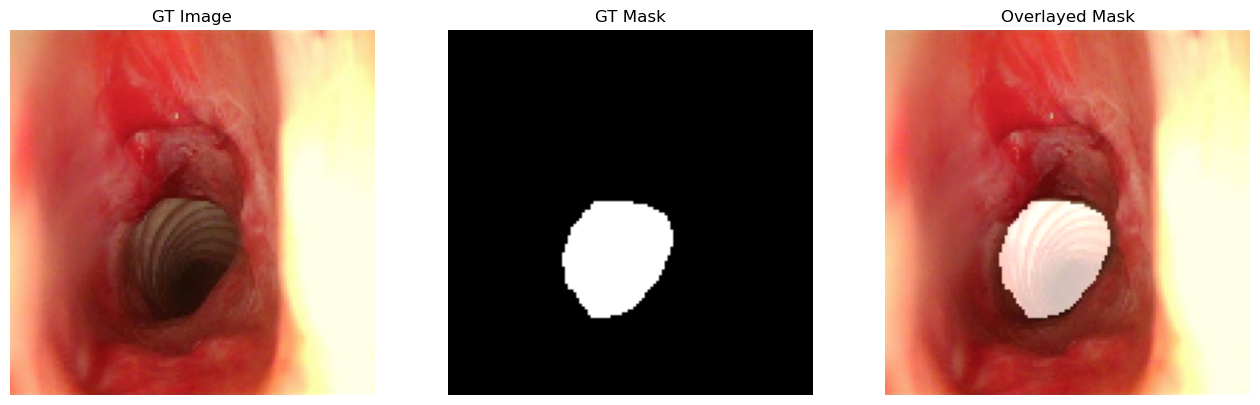

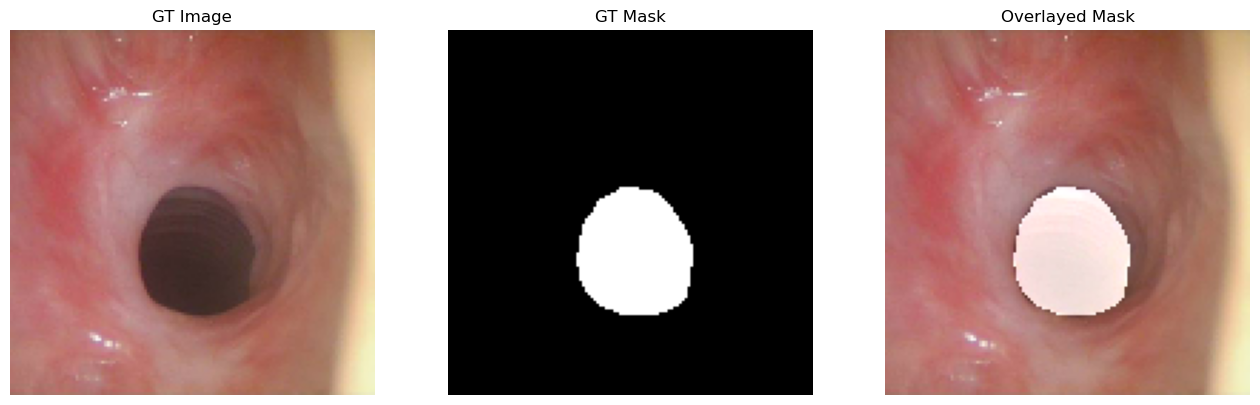

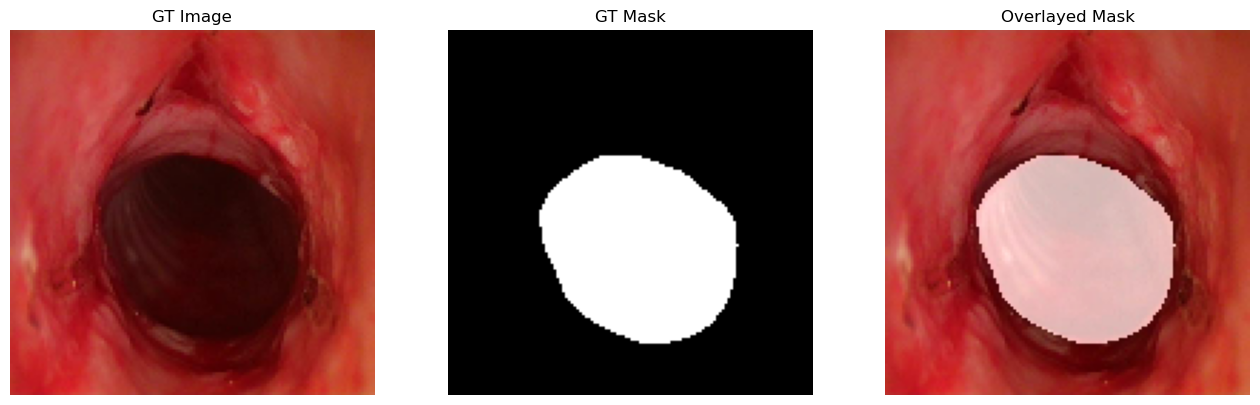

In [23]:
plot_train_ds = train_ds.map(iu.unpackage_inputs).batch(3)
image_batch, mask_batch = next(iter(plot_train_ds.take(1)))

titles = ["GT Image", "GT Mask", "Overlayed Mask"]

for image, gt_mask in zip(image_batch, mask_batch):
    gt_mask = tf.squeeze(gt_mask, axis=-1).numpy()
    display_image_and_mask(
        [image.numpy().astype(np.uint8), gt_mask],
        title_list=titles,
        figsize=(16, 6),
        color_mask=True,
    )

## Data Augmentation

We will use the following transforms as augmentations:
* RandomFlip (default mode is **"horizontal"**, with a probability of `0.5`)
* Random Brightness
* Random Contrast

In [24]:
augment_fn = tf.keras.Sequential(
    [
        keras_cv.layers.RandomFlip(),
        keras_cv.layers.RandomBrightness(
            factor=data_config.BRIGHTNESS_FACTOR, value_range=(0, 255)
        ),
        keras_cv.layers.RandomContrast(
            factor=data_config.CONTRAST_FACTOR, value_range=(0, 255)
        ),
    ]
)

In [25]:
train_dataset = (
    train_ds.shuffle(data_config.BATCH_SIZE)
    .map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(data_config.BATCH_SIZE)
    .map(iu.unpackage_inputs)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

valid_dataset = (
    valid_ds.batch(data_config.BATCH_SIZE)
    .map(iu.unpackage_inputs)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_dataset = (
    test_ds.batch(data_config.BATCH_SIZE)
    .map(iu.unpackage_inputs)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

2024-02-28 20:53:19.296914: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Let's visualized a few images and their segmentation masks from the training data, with
the `keras_cv.visualization.plot_segmentation_mask_gallery` API.

### Visualize Augmented Data

2024-02-28 20:53:20.905024: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 931805679661918288
2024-02-28 20:53:20.905197: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 931805679661918288
2024-02-28 20:53:20.905268: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 931805679661918288
2024-02-28 20:53:20.905317: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 931805679661918288
2024-02-28 20:53:20.905379: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 931805679661918288
2024-02-28 20:53:20.905389: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 12893270030483294092
2024-02-28 20:53:20.905436: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item ca

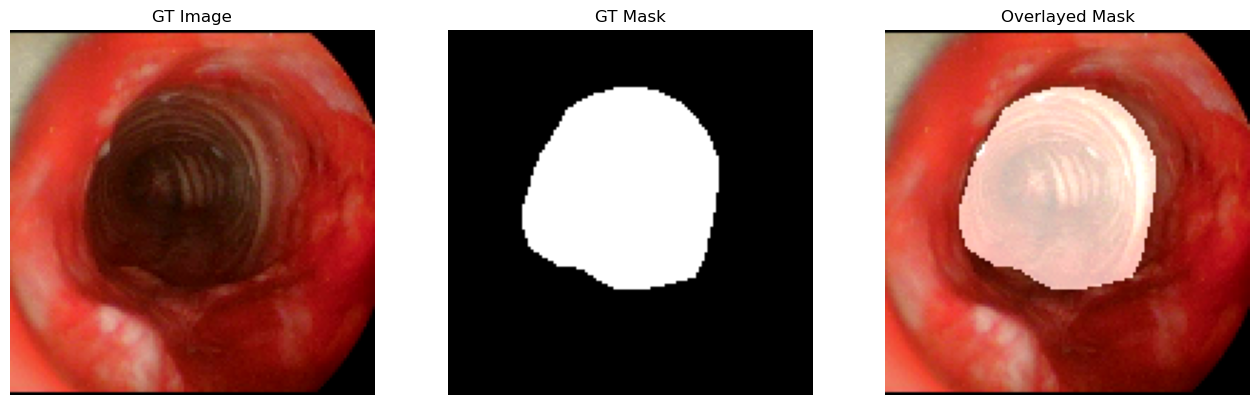

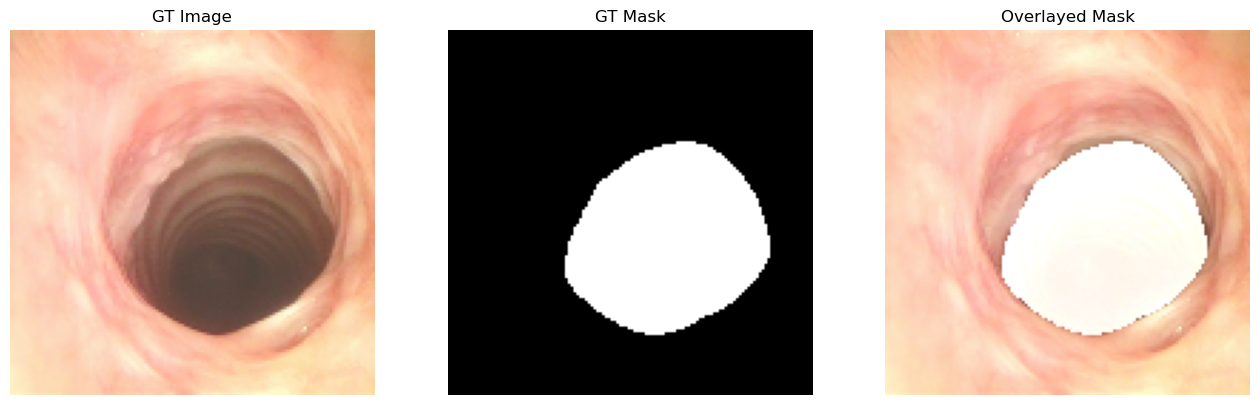

In [26]:
image_batch, aug_mask_batch = next(iter(train_dataset.take(1)))

titles = ["GT Image", "GT Mask", "Overlayed Mask"]

for idx, (image, gt_mask) in enumerate(zip(image_batch, aug_mask_batch)):
    if idx > 1:
        break
    gt_mask = tf.squeeze(gt_mask, axis=-1).numpy()
    display_image_and_mask(
        [image.numpy().astype(np.uint8), gt_mask],
        title_list=titles,
        figsize=(16, 6),
        color_mask=False,
    )

## Model Architecture

We will use `resnet50_v2_imagenet` feature extractor on top of the TransUnet Head.

In [27]:
backbone = keras_cv.models.ResNet50V2Backbone.from_preset(
    preset=train_config.MODEL,
    input_shape=data_config.IMAGE_SIZE + (3,),
    load_weights=True,
)

model = models.transunet_2d(
    (DatasetConfig.IMAGE_SIZE[0], DatasetConfig.IMAGE_SIZE[1], 3),
    filter_num=[64, 128, 256, 512],
    n_labels=12,
    stack_num_down=2,
    stack_num_up=2,
    embed_dim=768,
    num_mlp=3072,
    num_heads=12,
    num_transformer=12,
    activation="ReLU",
    mlp_activation="GELU",
    output_activation="Softmax",
    batch_norm=True,
    pool=True,
    unpool="bilinear",
    #backbone="ResNet50V2",
    #weights='imagenet', 
    name="transunet",
)

# model = keras_cv.models.segmentation.DeepLabV3Plus(
# num_classes=data_config.NUM_CLASSES, backbone=backbone,
# )

# print(model.summary())

## Evaluation Metrics

Intersection over Union (IoU) is a metric often used in segmentation problems to assess the model's accuracy. It provides a more intuitive basis for accuracy that is not biased by the (unbalanced) percentage of pixels from any particular class. Given two segmentation masks, `A` and `B`, the IoU is defined as follows:

$$ 
IoU = \frac{|A\cap B\hspace{1mm}|}{|A\cup B\hspace{1mm}|} \hspace{2mm}
$$

When there are multiple classes and inferences, we assess the model's performance by computing the mean IoU.

The function below computes the mean IoU that only considers the classes that are present in the ground truth mask or the predicted segmentation map (sometimes referred to as classwise mean IoU). This computation is a better representation of the metric since it only considers the relevant classes. **This is the metric computation we use for mean IoU.**

### Tensorboard and ModelCheckpoint Callbacks

In [29]:
def get_callbacks(
    train_config,
    monitor="val_mean_iou",
    mode="max",
    save_weights_only=True,
    save_best_only=True,
):
    # Initialize tensorboard callback for logging.
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=train_config.LOGS_DIR,
        histogram_freq=20,
        write_graph=False,
        update_freq="epoch",
    )

    # Update file path if saving best model weights.
    if save_weights_only:
        checkpoint_filepath = train_config.CKPT_DIR

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=save_weights_only,
        monitor=monitor,
        mode=mode,
        save_best_only=save_best_only,
        verbose=1,
    )

    return [tensorboard_callback, model_checkpoint_callback]

## Train the model

Now let's create the model, compile and train by calling `model.fit()` using the configurations defined in the `Trainingconfig` class.

In [30]:
# Build model.

# Get callbacks.
callbacks = get_callbacks(train_config)
# Define Loss.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# Compile model.
model.compile(
    optimizer=tf.keras.optimizers.Adam(train_config.LEARNING_RATE),
    loss=loss_fn,
    metrics=["accuracy", metrics.mean_iou],
)

In [31]:
# Train the model, doing validation at the end of each epoch.
history = model.fit(
    train_dataset,
    epochs=train_config.EPOCHS,
    validation_data=valid_dataset,
    callbacks=callbacks,
)

Epoch 1/200


2024-02-28 20:53:31.974104: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-02-28 20:53:32.141810: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-28 20:53:33.047384: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8dc2b5e7e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-28 20:53:33.047416: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090 Laptop GPU, Compute Capability 8.9
2024-02-28 20:53:33.053150: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-28 20:53:33.108552: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-02-28 20:53:33.279

18/18 [==============================] - ETA: 0s - loss: 1.8631 - accuracy: 0.5819 - mean_iou: 0.0904
Epoch 1: val_mean_iou improved from -inf to 0.10419, saving model to checkpoints_resnet50_v2/transunet_resnet50_v2.h5
18/18 [==============================] - 44s 2s/step - loss: 1.8631 - accuracy: 0.5819 - mean_iou: 0.0904 - val_loss: 1.6751 - val_accuracy: 0.6732 - val_mean_iou: 0.1042
Epoch 2/200
18/18 [==============================] - ETA: 0s - loss: 1.1358 - accuracy: 0.9214 - mean_iou: 0.1678
Epoch 2: val_mean_iou did not improve from 0.10419
18/18 [==============================] - 14s 759ms/step - loss: 1.1358 - accuracy: 0.9214 - mean_iou: 0.1678 - val_loss: 3.4615 - val_accuracy: 0.1871 - val_mean_iou: 0.0745
Epoch 3/200
18/18 [==============================] - ETA: 0s - loss: 0.8780 - accuracy: 0.9541 - mean_iou: 0.3315
Epoch 3: val_mean_iou did not improve from 0.10419
18/18 [==============================] - 14s 755ms/step - loss: 0.8780 - accuracy: 0.9541 - mean_iou: 0.3

## Plot hostogram of the training results

In [32]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'mean_iou', 'val_loss', 'val_accuracy', 'val_mean_iou'])


In [33]:
# convert the history.history dict to a pandas DataFrame:
#hist_df = pd.DataFrame(history.history)
hist_df = pd.DataFrame()
# datetime object containing current date and time
now = datetime.now()
# dd/mm/YY H:M:S
dt_string = now.strftime("%d-%m-%Y_%H.%M.%S")

# save to csv:
hist_csv_file = train_config.HIST_DIR + '/' + train_config.MODEL + '_'  + dt_string + ".csv"
print(hist_csv_file)
with open(hist_csv_file, mode="w") as f:
    hist_df.to_csv(f)

In [34]:
print(hist_df)

         loss  accuracy  mean_iou  val_loss  val_accuracy  val_mean_iou
0    1.863111  0.581888  0.090423  1.675119      0.673245      0.104191
1    1.135770  0.921394  0.167756  3.461498      0.187073      0.074466
2    0.878010  0.954070  0.331507  2.773721      0.205465      0.085796
3    0.749411  0.965555  0.561043  2.961495      0.274177      0.091516
4    0.680493  0.965309  0.716861  2.553688      0.364855      0.121148
..        ...       ...       ...       ...           ...           ...
195  0.017509  0.994169  0.968373  0.125893      0.969259      0.908972
196  0.016423  0.994379  0.969375  0.099893      0.971110      0.909152
197  0.016144  0.994521  0.970123  0.109187      0.971171      0.915994
198  0.015642  0.994687  0.970859  0.128138      0.968024      0.908693
199  0.014889  0.994956  0.972797  0.178203      0.963067      0.901524

[200 rows x 6 columns]


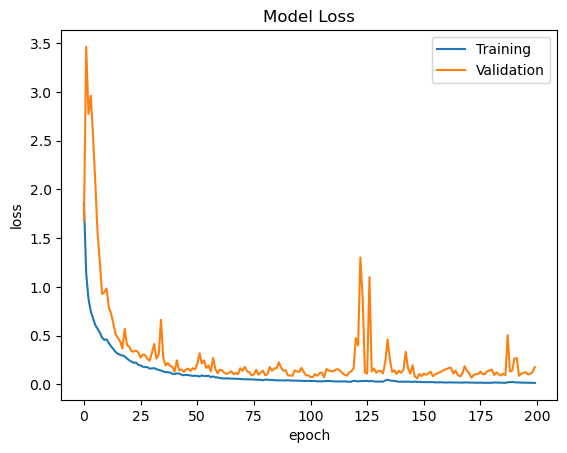

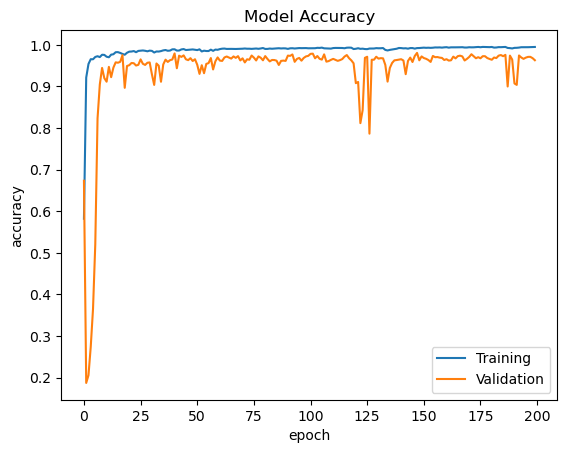

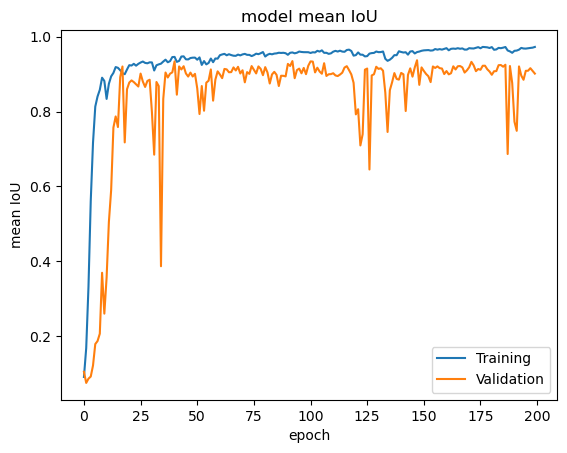

In [35]:
# summarize history for loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["Training", "Validation"], loc="upper right")
plt.show()

# summarize history for accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["Training", "Validation"], loc="lower right")
plt.show()


# summarize history for mean_iou
plt.plot(history.history["mean_iou"])
plt.plot(history.history["val_mean_iou"])
plt.title("model mean IoU")
plt.ylabel("mean IoU")
plt.xlabel("epoch")
plt.legend(["Training", "Validation"], loc="lower right")
plt.show()

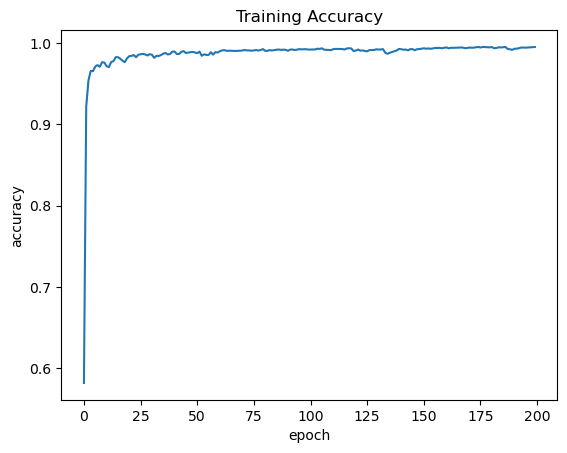

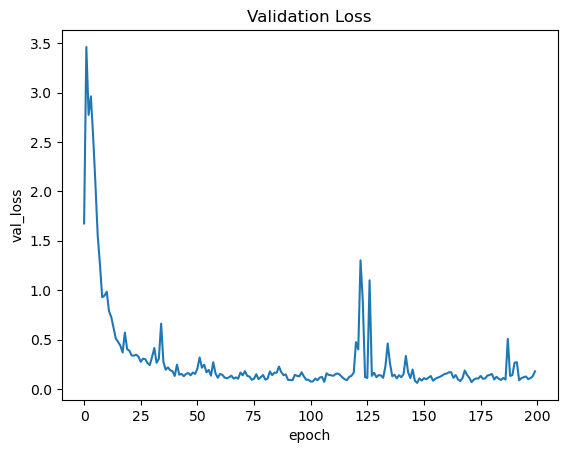

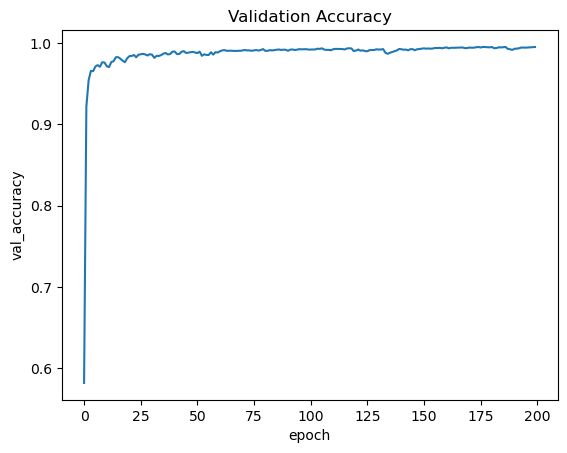

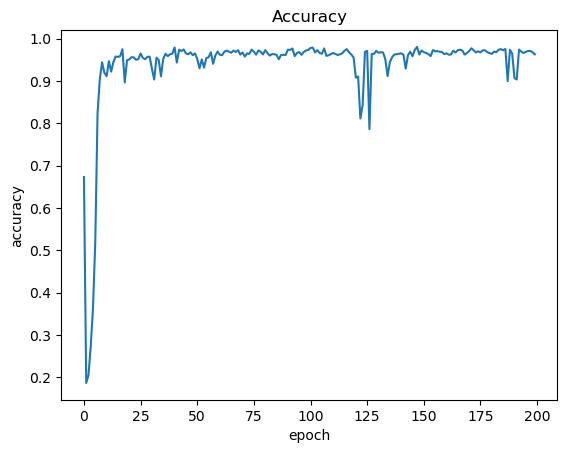

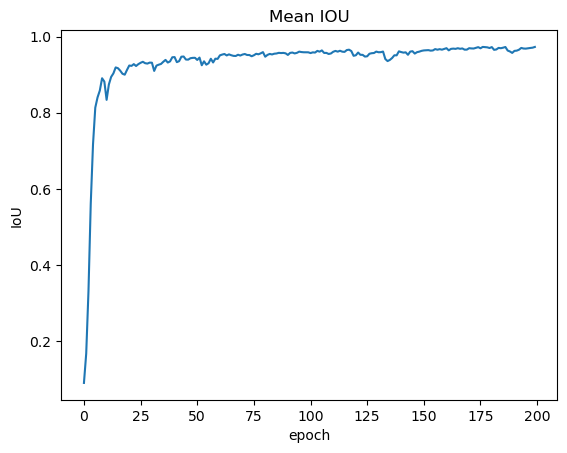

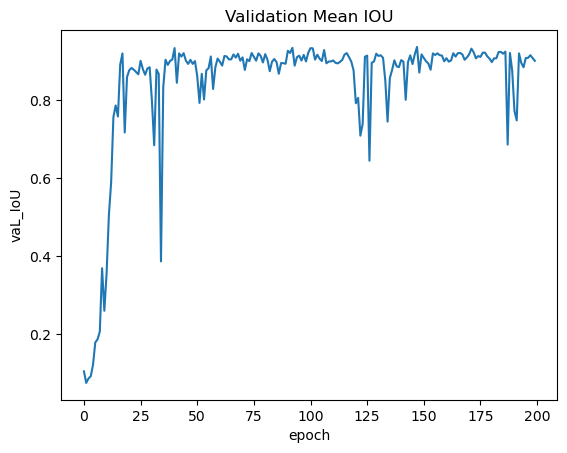

In [36]:
plt.plot(history.history["loss"])
plt.title("Training loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["mean_iou"])
plt.title("Training Mean IOU")
plt.ylabel("IoU")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_mean_iou"])
plt.title("Validation Mean IOU")
plt.ylabel("vaL_IoU")
plt.xlabel("epoch")
plt.show()

#### Load Fine-tuned Model Weights

In [37]:
model.load_weights(train_config.CKPT_DIR)

#### Perform Evaluation

In [38]:
evaluate = model.evaluate(test_dataset)
#print(evaluate)

3/3 [==============================] - 1s 190ms/step - loss: 0.0981 - accuracy: 0.9727 - mean_iou: 0.9025


## Prediction with Fine-tuned Model

Now that the model training of DeepLabv3 has been completed, let's test it by making predictions on a few sample images.

In [39]:
def inference(model, dataset, samples_to_plot):
    num_batches_to_process = 3
    count = 0
    stop_plot = False

    titles = ["Image", "GT Mask", "Pred Mask", "Overlayed Prediction"]

    for idx, data in enumerate(dataset):
        if stop_plot:
            break

        batch_img, batch_mask = data[0], data[1]
        batch_pred = (model.predict(batch_img)).astype("float32")
        batch_pred = batch_pred.argmax(axis=-1)

        batch_img = batch_img.numpy().astype("uint8")
        batch_mask = batch_mask.numpy().squeeze(axis=-1)

        for image, mask, pred in zip(batch_img, batch_mask, batch_pred):
            count += 1
            display_image_and_mask(
                [image, mask, pred], title_list=titles, figsize=(20, 8), color_mask=True
            )
            if count >= samples_to_plot:
                stop_plot = True
                break

1/1 [==============================] - 1s 1s/step


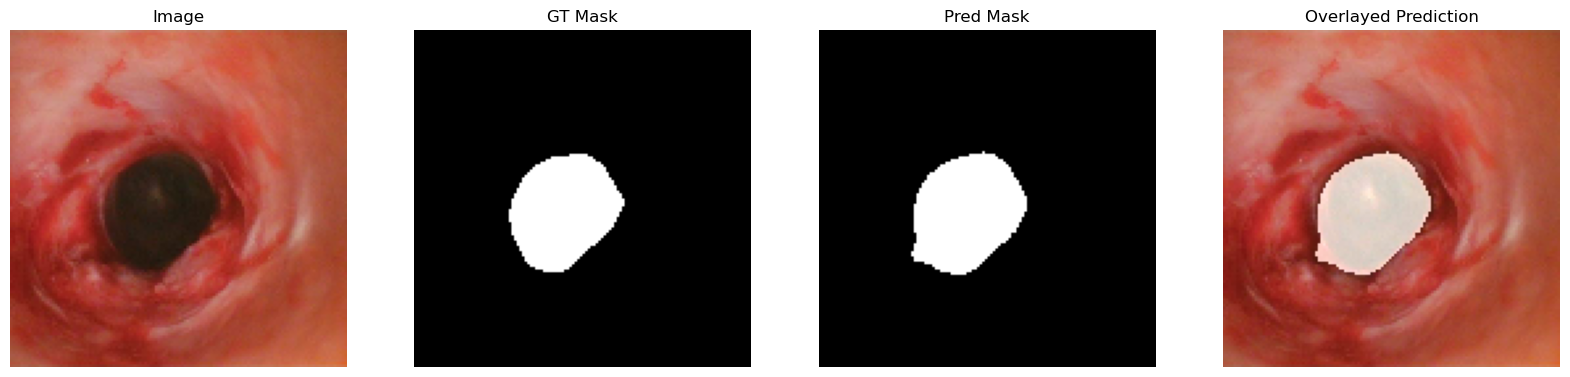

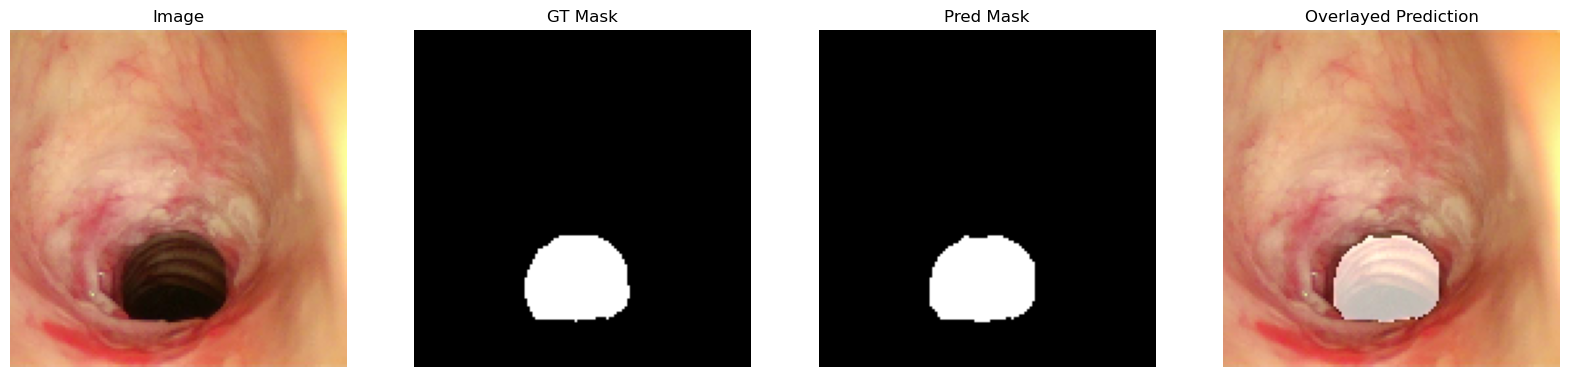

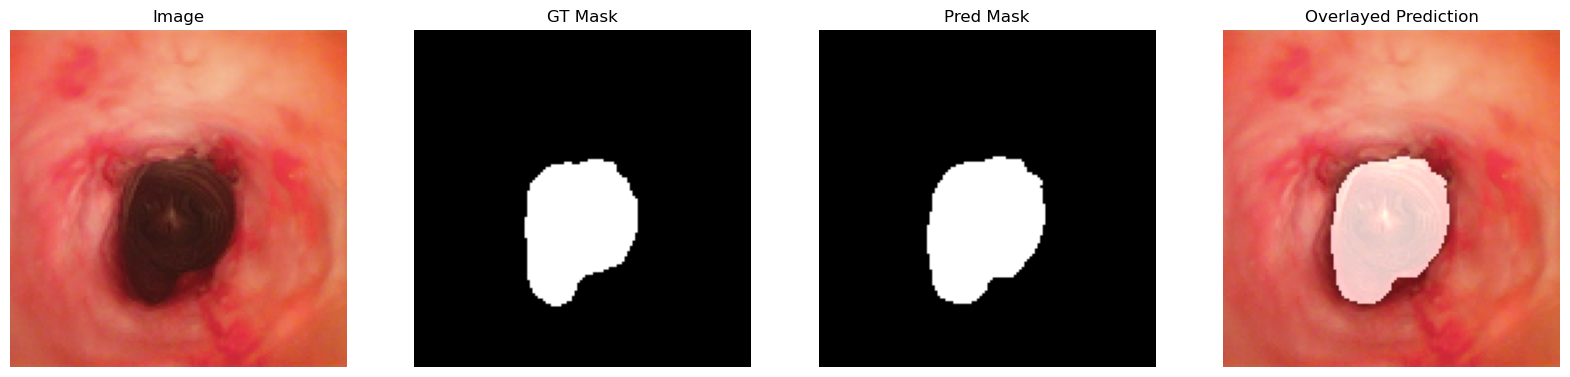

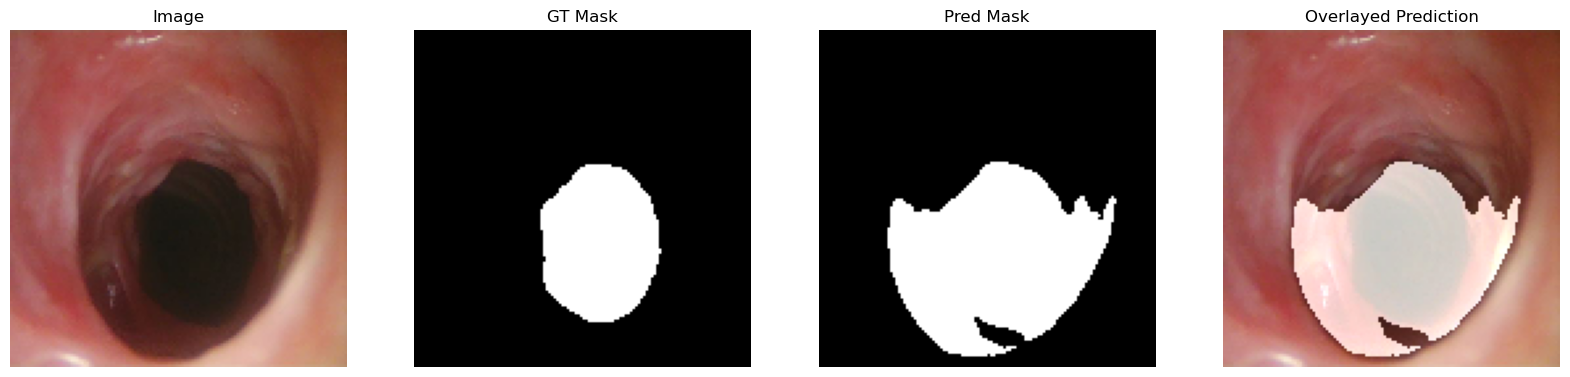

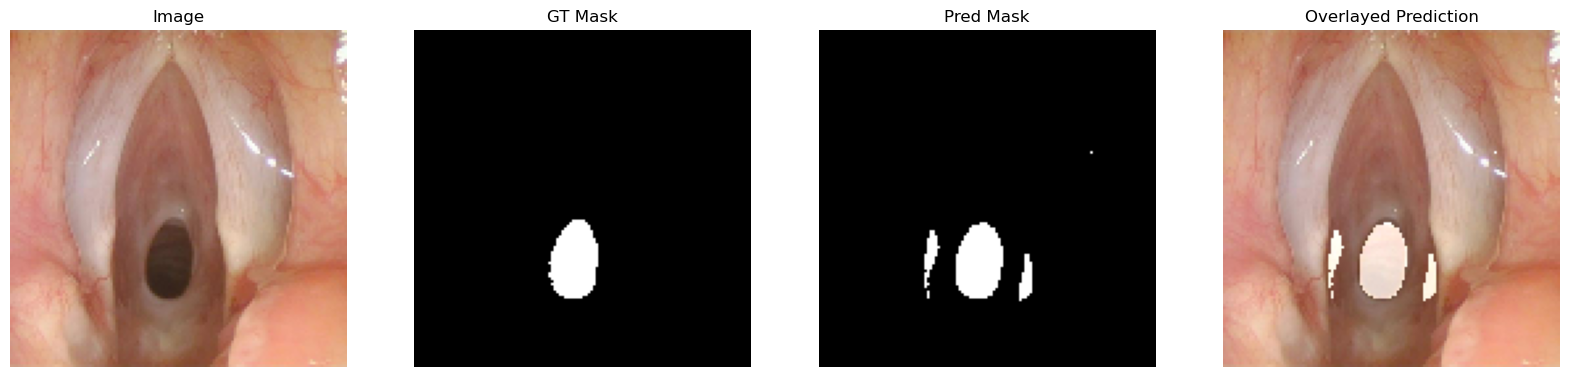

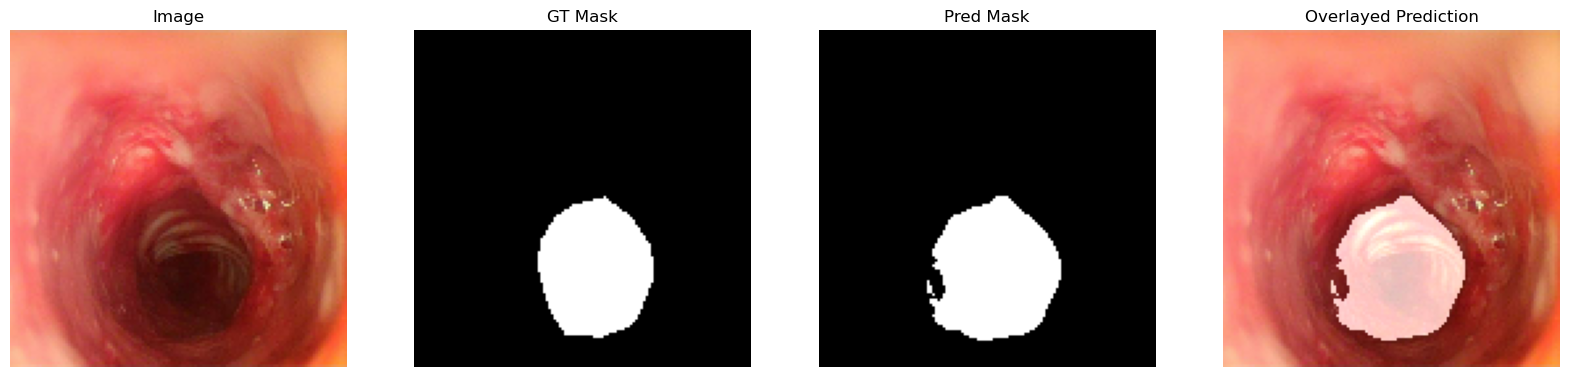

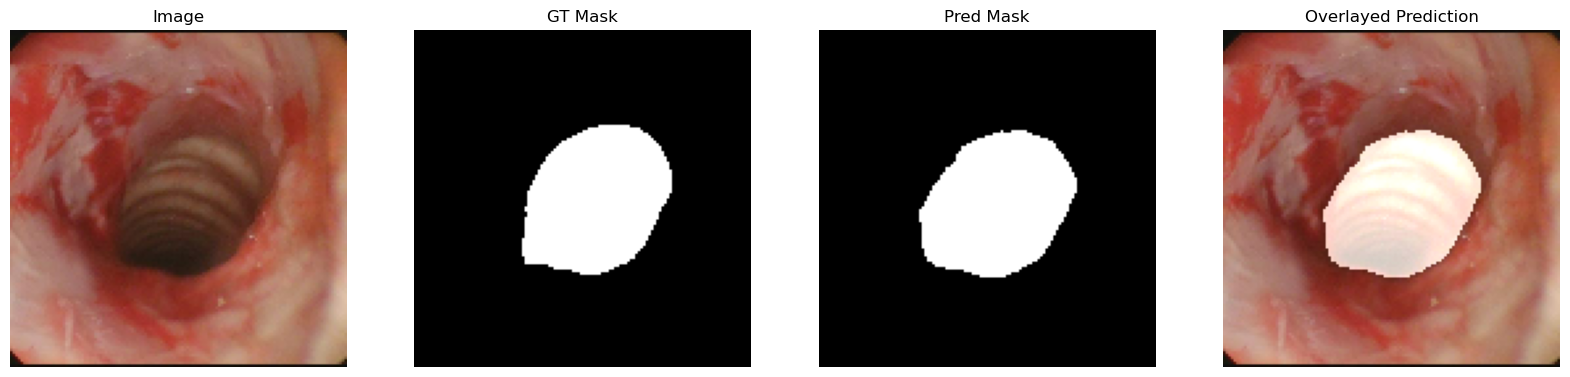

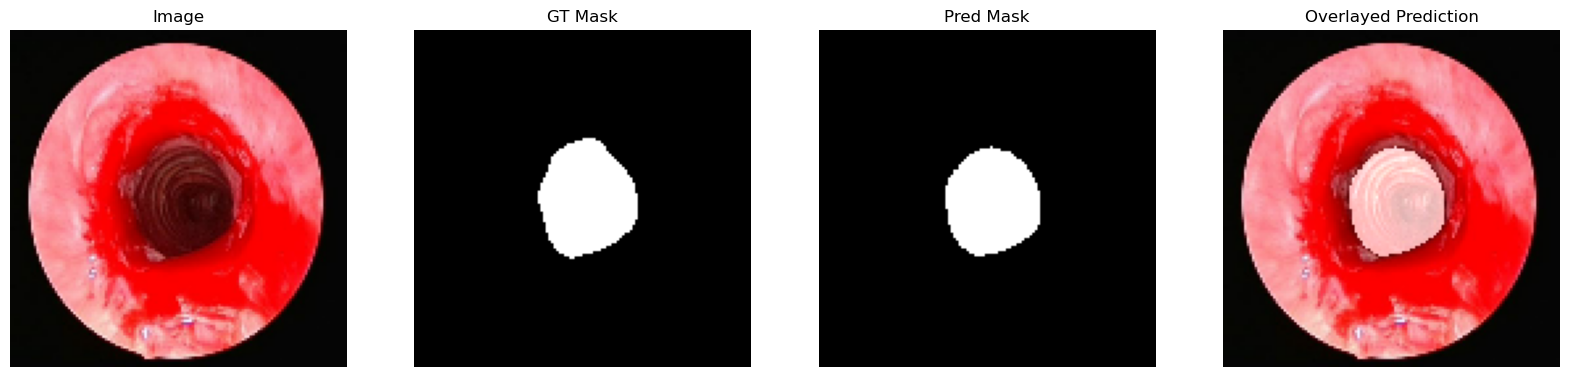

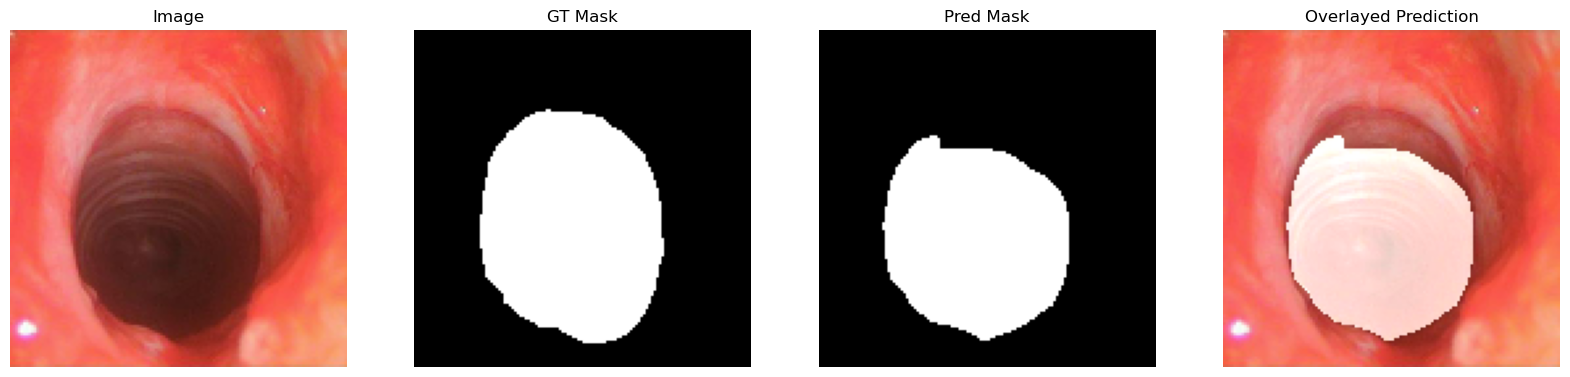

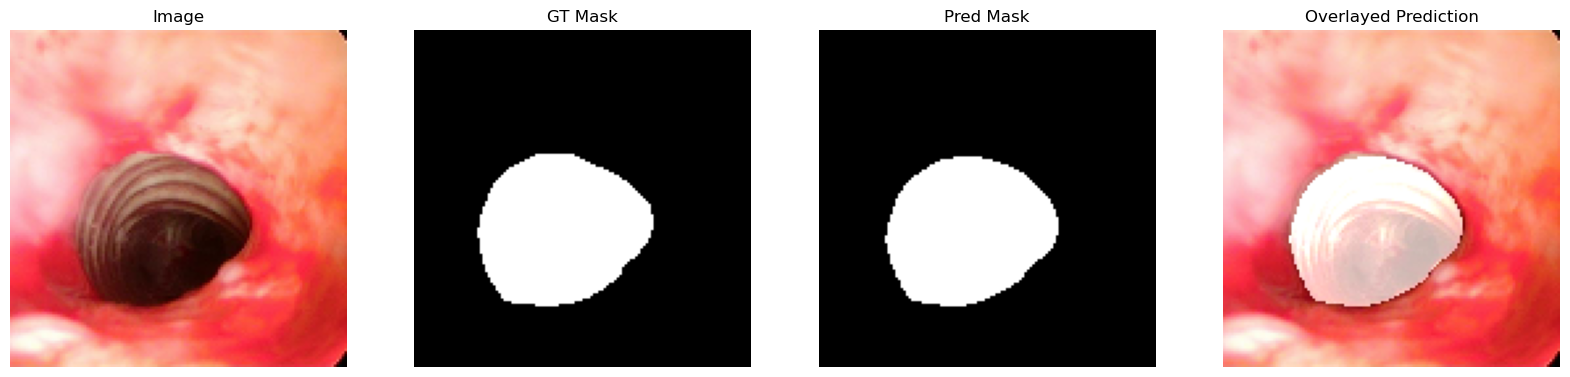

In [40]:
inference(model, test_dataset, samples_to_plot=10)